# GRU Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from collections import Counter

In [ ]:
# Load the training dataset containing text and corresponding emoji labels
df = pd.read_csv("Train.csv")

# Load the mapping file that maps numeric labels to actual emoticons
mapping = pd.read_csv('Mapping.csv')
# Create a dictionary to map numeric labels to their corresponding emoticons
# 'number' column contains label IDs, 'emoticons' column contains emoji strings
emoji_map = dict(zip(mapping["number"], mapping["emoticons"]))

# Load the test dataset containing tweet text
test_df = pd.read_csv("Test.csv")

## Create Vocabulary Dictionary from Text Data

In [3]:
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        # Count all words in lowercase
        counter.update(text.lower().split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, freq in counter.items():
        # Add word to vocab if it meets frequency threshold
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Prepare text and labels for processing
texts = df['TEXT'].tolist()
labels = df['Label'].tolist()
# Generate vocabulary
vocab = build_vocab(texts)
# Set sequence processing parameters
max_len = 30
pad_idx = vocab['<PAD>']
unk_idx = vocab['<UNK>']

## Encode text and Dataloaders

In [9]:
def encode(text, vocab, max_len):
    # Split text into lowercase tokens
    tokens = text.lower().split()
    indices = [vocab.get(tok, unk_idx) for tok in tokens]
    if len(indices) < max_len:
        indices += [pad_idx] * (max_len - len(indices))
    # Trim if longer than max_len
    return indices[:max_len]

# Convert all texts and labels to tensors
X = torch.tensor([encode(t, vocab, max_len) for t in texts])
y = torch.tensor(labels)


# Create dataset and data loader for training
train_ds = TensorDataset(X, y)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

## Build GRU model

In [16]:
# Total number of tokens in vocabulary
vocab_size = len(vocab)
# Size of word embeddings
embed_dim = 100
hidden_dim = 128
num_classes = 20

# Layers for the first model version
embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
fc = nn.Linear(hidden_dim * 2, num_classes)
dropout = nn.Dropout(0.3)

def forward(x):
    # Embed tokens
    x = embedding(x)
    x, _ = gru(x)
    # Mean pooling over time steps
    x = torch.mean(x, dim=1)
    x = dropout(x)   
    # Final classification layer
    return fc(x)

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.gru(x)
        h = h.squeeze(0)                 
        # Predict class
        out = self.fc(h)
        return out

## Training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize GRU model
model = GRUModel(vocab_size, embed_dim, hidden_dim, num_classes).to(device)

# Move separately defined layers to the same device
embedding = embedding.to(device)
gru = gru.to(device)
fc = fc.to(device)
dropout = dropout.to(device)

# Combine parameters from all layers for optimization
params = list(embedding.parameters()) + list(gru.parameters()) + \
         list(fc.parameters()) + list(dropout.parameters())

# Set optimizer with learning rate
optimizer = torch.optim.Adam(params, lr=1e-3)
# Define loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

In [32]:
train_losses = []
# Loop over 5 training epochs
for epoch in range(5):
    # Set model to training mode
    model.train()
    total_loss = 0

    print(f"\nEpoch {epoch+1} starting...")
    
    # Loop through batches from the dataloader
    for i, (xb, yb) in enumerate(train_dl):
        xb, yb = xb.to(device), yb.to(device)

        # clear gradients, forward pass, compute loss, backpropagate, and update weights
        optimizer.zero_grad()
        out = forward(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Print loss every 1000 batches
        if i % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_dl)}, Loss: {loss.item():.4f}")
            
    # Calculate and store average loss for the epoch
    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} complete. Avg Loss: {avg_loss:.4f}")


Epoch 1 starting...
Epoch 1, Batch 1/4375, Loss: 0.5580
Epoch 1, Batch 1001/4375, Loss: 0.7832
Epoch 1, Batch 2001/4375, Loss: 0.2652
Epoch 1, Batch 3001/4375, Loss: 0.6369
Epoch 1, Batch 4001/4375, Loss: 0.8143
Epoch 1 complete. Avg Loss: 0.6312

Epoch 2 starting...
Epoch 2, Batch 1/4375, Loss: 1.0023
Epoch 2, Batch 1001/4375, Loss: 0.2308
Epoch 2, Batch 2001/4375, Loss: 0.8120
Epoch 2, Batch 3001/4375, Loss: 0.7042
Epoch 2, Batch 4001/4375, Loss: 1.0778
Epoch 2 complete. Avg Loss: 0.4008

Epoch 3 starting...
Epoch 3, Batch 1/4375, Loss: 0.4498
Epoch 3, Batch 1001/4375, Loss: 0.1753
Epoch 3, Batch 2001/4375, Loss: 0.1086
Epoch 3, Batch 3001/4375, Loss: 0.3189
Epoch 3, Batch 4001/4375, Loss: 0.2361
Epoch 3 complete. Avg Loss: 0.2662

Epoch 4 starting...
Epoch 4, Batch 1/4375, Loss: 0.0564
Epoch 4, Batch 1001/4375, Loss: 0.0541
Epoch 4, Batch 2001/4375, Loss: 0.0536
Epoch 4, Batch 3001/4375, Loss: 0.1583
Epoch 4, Batch 4001/4375, Loss: 0.1610
Epoch 4 complete. Avg Loss: 0.1869

Epoch 5

The training shows steady improvement over 5 epochs. The loss started high at 0.63 in epoch 1 and gradually decreased each epoch, reaching 0.14 by epoch 5. This means the model got better and more stable with training.

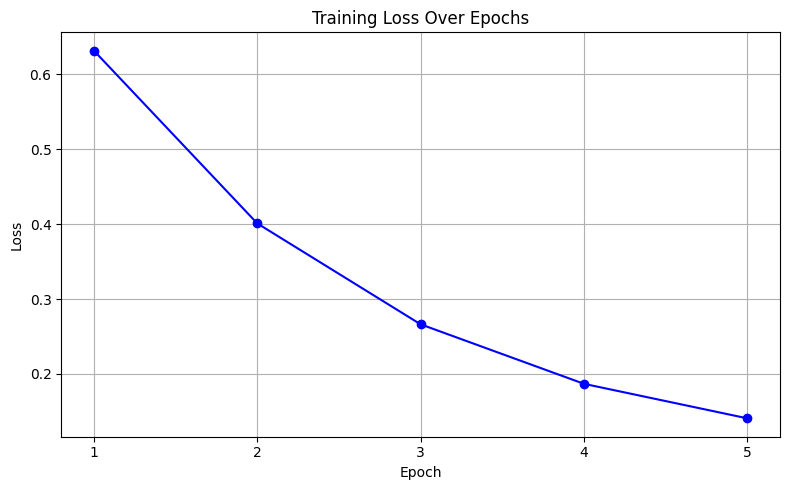

In [33]:
# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), train_losses, marker='o', color='blue')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluation

In [35]:
# Predict emoji probabilities for a given tweet using the trained GRU model
def predict(text):
    embedding.eval(); gru.eval(); fc.eval(); dropout.eval()
    with torch.no_grad():
        encoded = torch.tensor([encode(text, vocab, max_len)]).to(device)
        output = forward(encoded)
        probs = F.softmax(output, dim=1).cpu().numpy().flatten()
    return probs

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# For the first 3 test tweets, predict emoji probabilities
test_tweets = test_df['TEXT'].tolist()[:3]
for tweet in test_tweets:
    probs = predict(tweet)
    top_indices = probs.argsort()[-3:][::-1]
    top_probs = [probs[i] for i in top_indices]
    
    # Print emoji predictions and confidence scores
    print("Top predicted emojis and confidence:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {emoji_map[idx]} — {top_probs[i]:.2f}")
    print()

Thought this was cool...#Repost (get_repost)・・・Colorview. by shay_images…
Top predicted emojis and confidence: 
 1. 🔥 — 0.99 
 2. 📷 — 0.00 
 3. 📸 — 0.00

Happy 4th! Corte madera parade. #everytownusa #merica @ Perry's on…
Top predicted emojis and confidence: 
 1. 🇺🇸 — 1.00 
 2. 😘 — 0.00 
 3. 😎 — 0.00

Luv. Or at least something close to it. @ Union Hill, Richmond, Virginia
Top predicted emojis and confidence: 
 1.  💯 — 0.94 
 2. 📸 — 0.05 
 3. 😜 — 0.01


## Conculsion
The GRU model delivers strong performance, especially on tweets with clear emotional or contextual cues. For example, it confidently predicts 🇺🇸 for Independence Day content and 📸 for posts referencing photos, often with high certainty. It also handles expressive language well, selecting emojis like 😍 and ✨ for affectionate or enthusiastic tweets. While its predictions are generally relevant, the model can be overly confident, which may lead to occasional misclassifications. Overall, GRU offers a good balance of efficiency and accuracy, making it a solid choice for emoji prediction on short, informal text.